In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ImportError: No module named 'matplotlib.artist'

# 1. Импортируем библиотеки

In [29]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [30]:
#import download_csv_data as downl         ### FIX ME

In [31]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
%watermark --iversions

pytz    2016.6.1
pyfolio 0.9.2
zipline v1.3.0
pandas  0.22.0
numpy   1.11.1



# 2. Загрузка данных

In [33]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

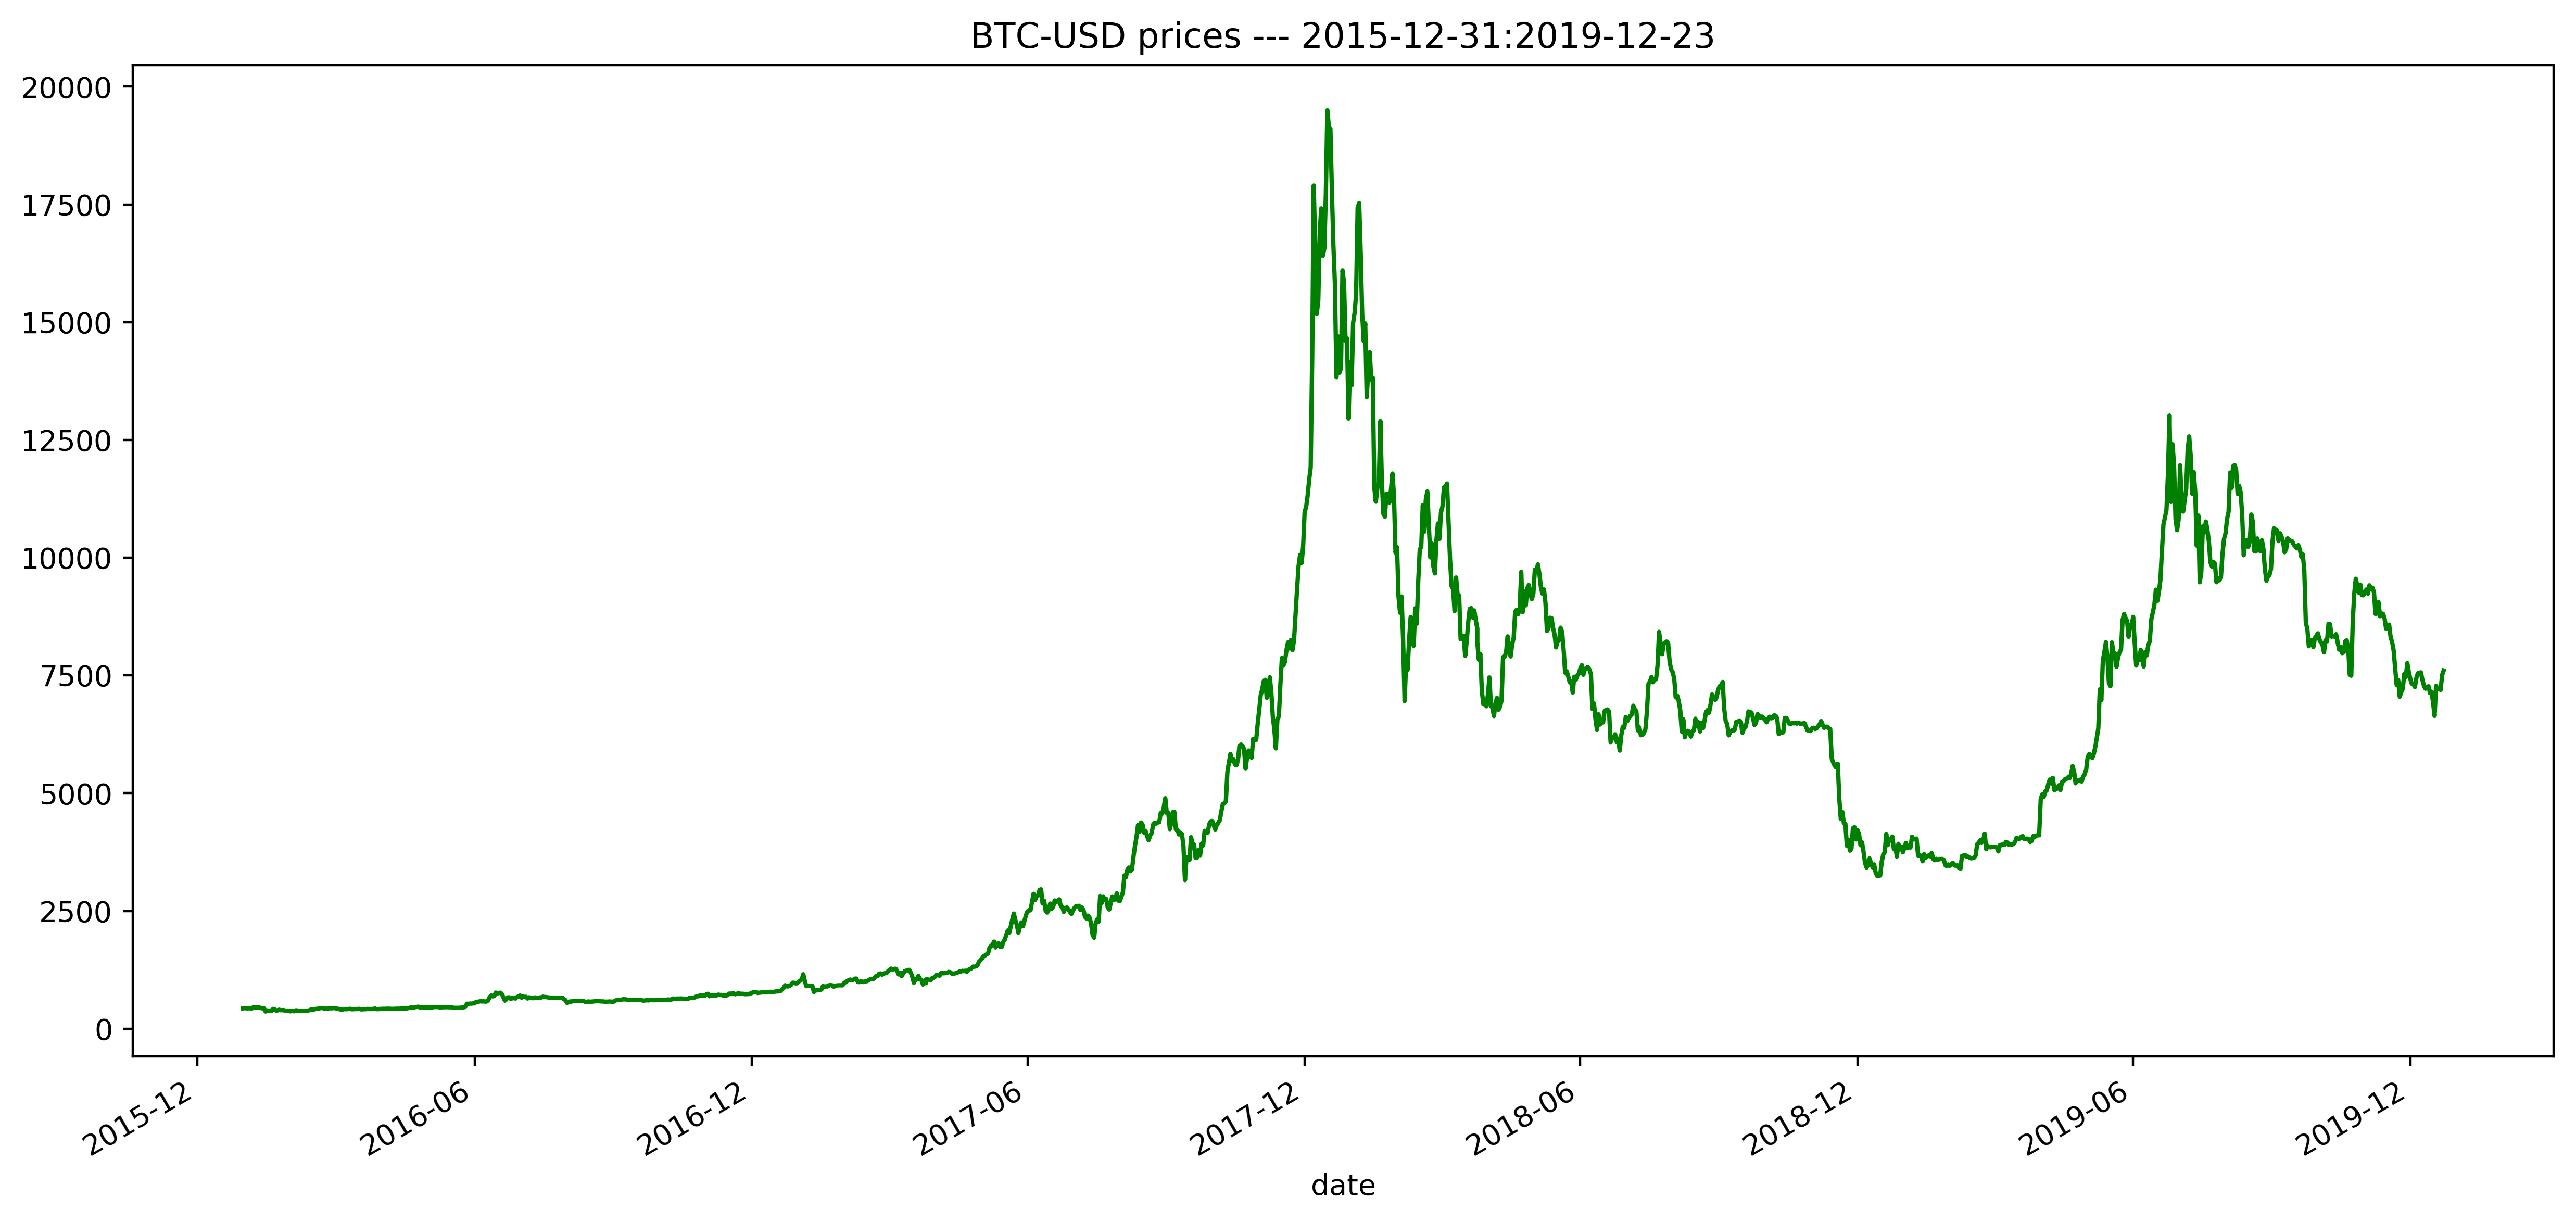

In [34]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-23', 
                  freq='daily', 
                  path='data/BTC.csv')

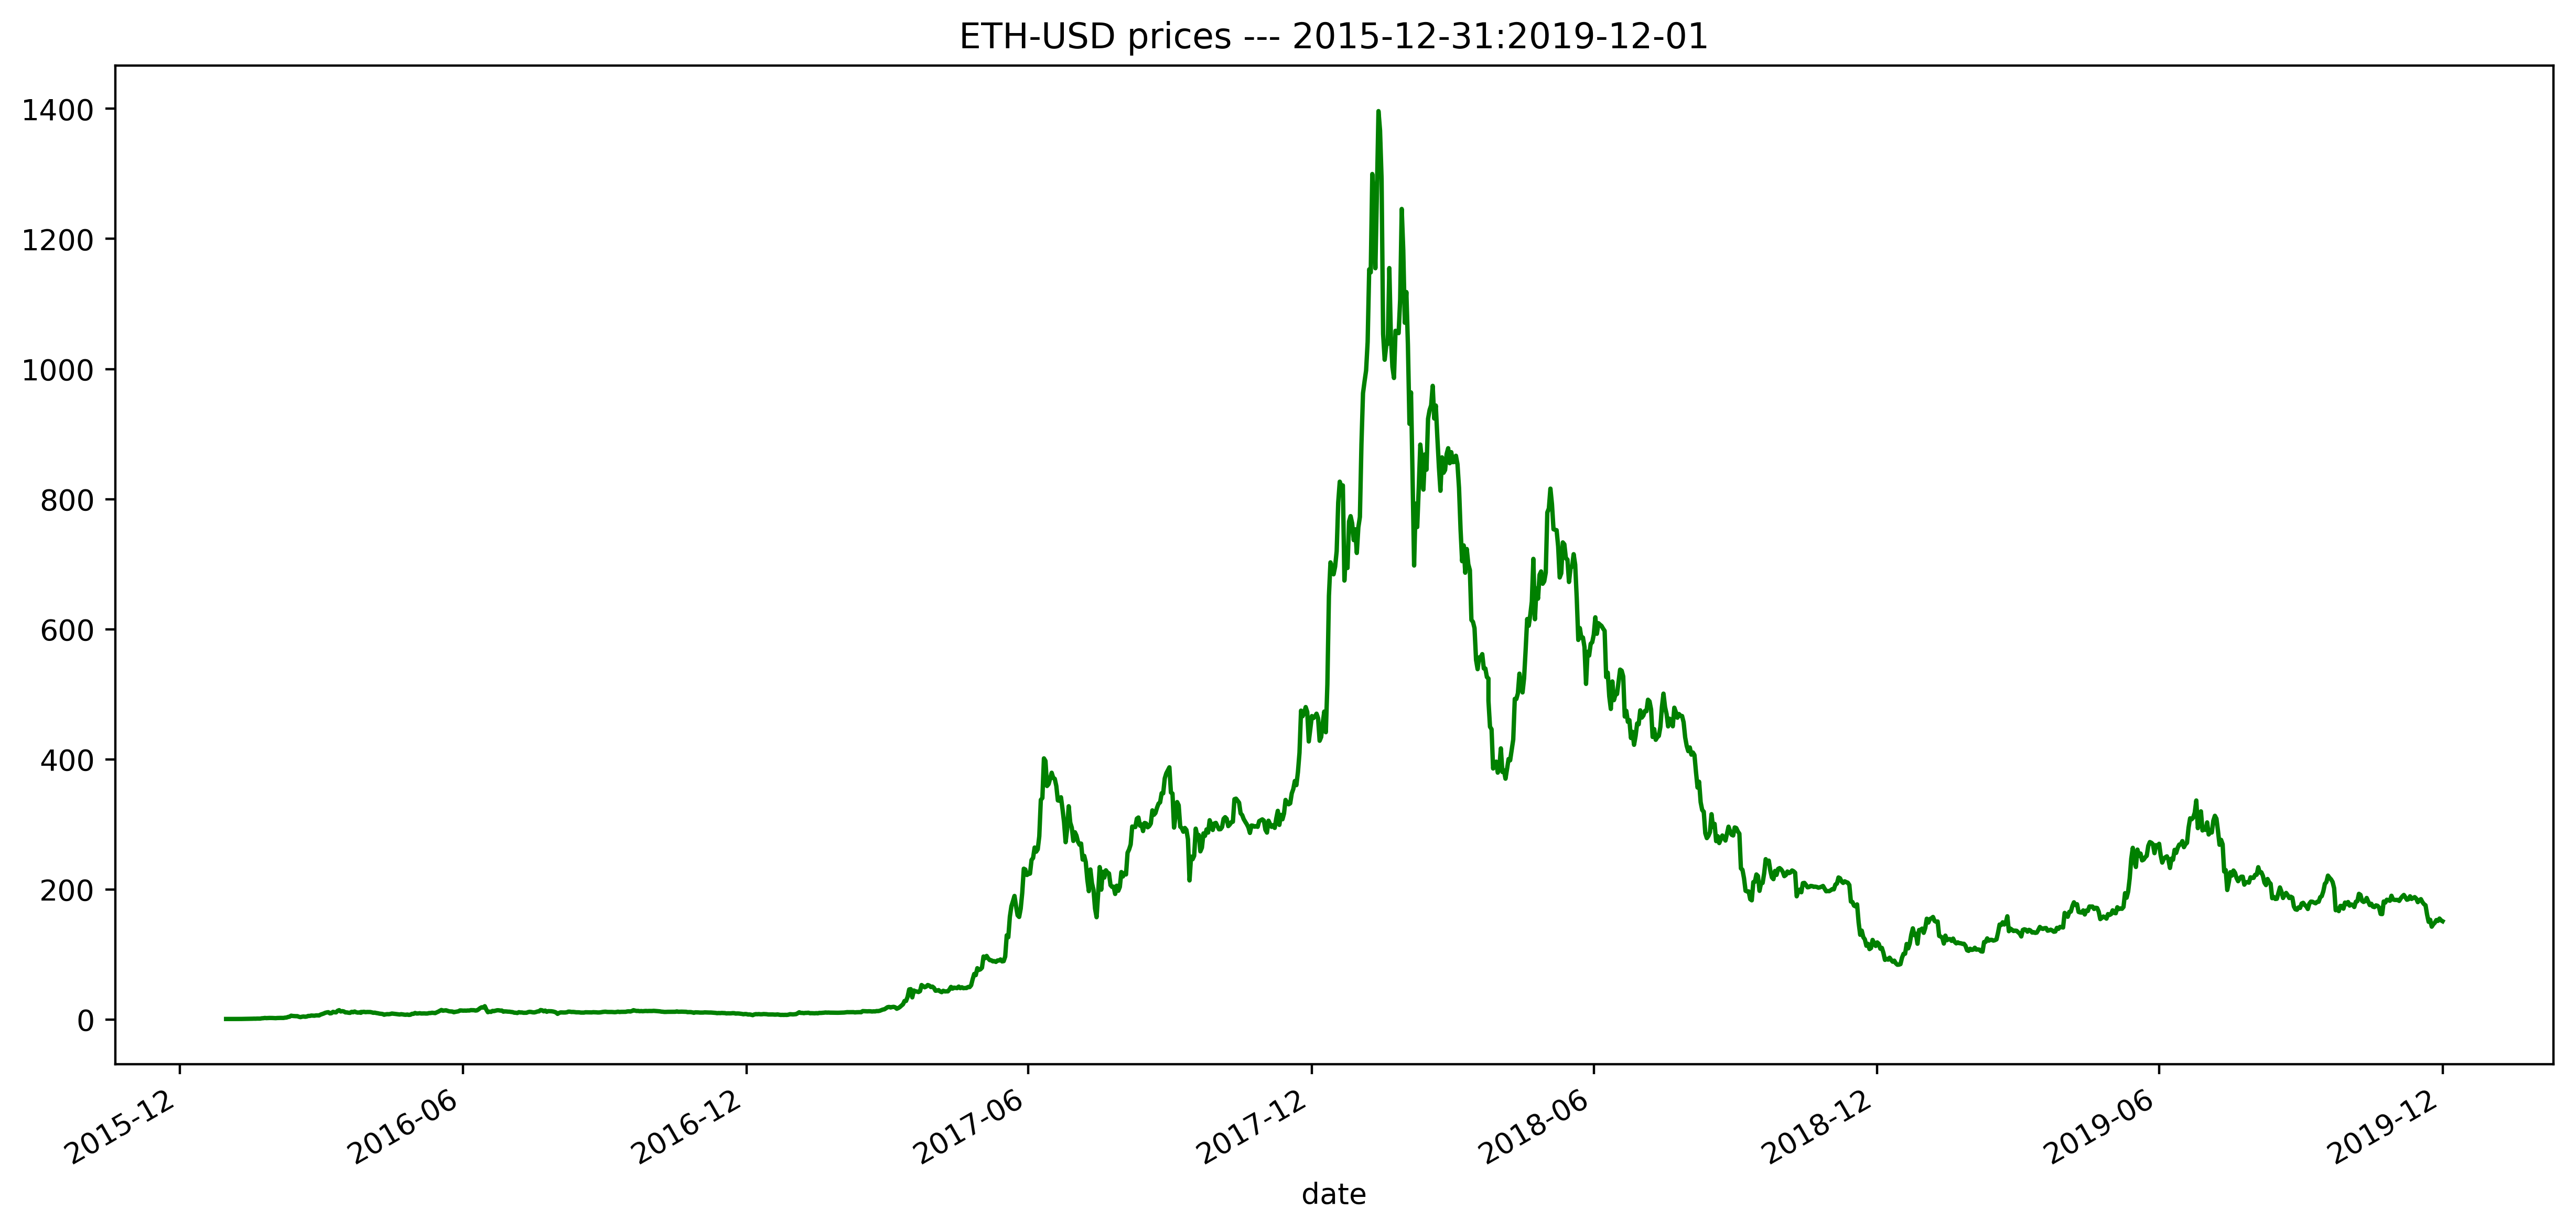

In [35]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-01', 
                  freq='daily', 
                  path='data/ETH.csv')

# 3. Strategy with fix rebalance period

## Формируем данные для анализа стратегии

In [36]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']
WEIGHTS = [0.55, 0.25]

In [37]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][["open","high","low","close","volume"]]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)

In [38]:
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1454 (major_axis) x 5 (minor_axis)
Items axis: BTC to ETH
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-23 00:00:00+00:00
Minor_axis axis: open to volume


## Определяем функции алгоритма

In [39]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=0.0007))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 30
    context.time = 0

In [40]:
def handle_data(context, data):
    
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
    
    context.time += 1

## Запускаем алгоритм

In [41]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 23, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000,
                              handle_data=handle_data,
                              data=panel)

In [15]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

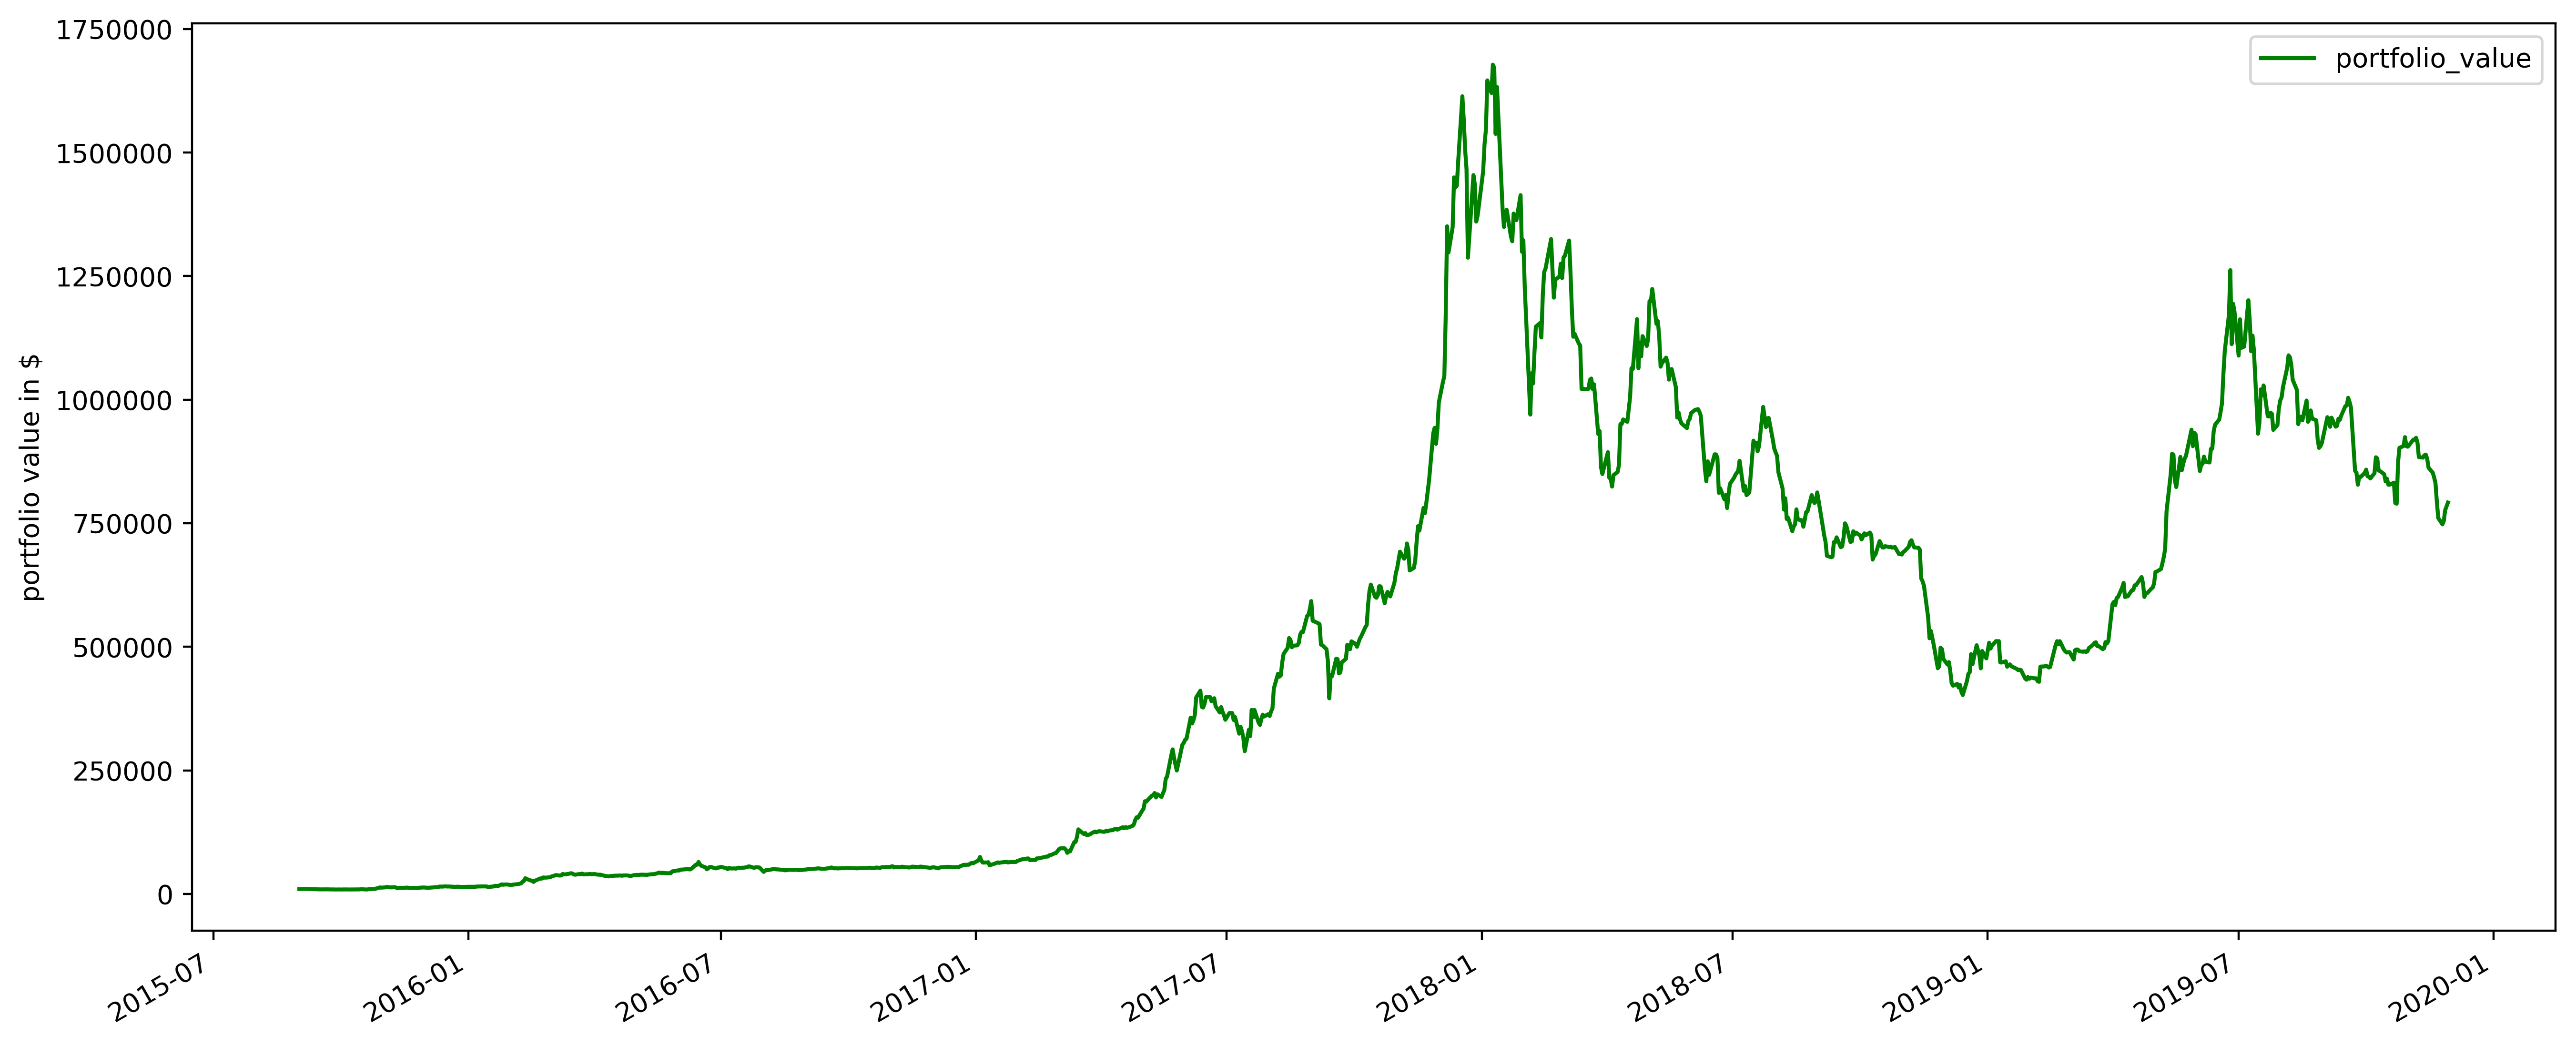

Final portfolio value (including cash): 791924.46$


In [16]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
perf.portfolio_value.plot(color='g')
ax.set_ylabel('portfolio value in $')
ax.tick_params(axis = 'x', direction = 'out')

plt.legend()
plt.show()

print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))

In [17]:
#perf.columns

In [18]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.tail()

,Equity(0 [ETH]),Equity(1 [BTC]),cash
2019-11-22,184679.584885,394015.192383,181948.495911
2019-11-25,180019.657806,385891.224609,181948.495911
2019-11-26,183078.074265,389792.039062,181948.495911
2019-11-27,188049.977112,406709.833008,181948.495911
2019-11-29,190868.804581,419107.157227,181948.495911


In [19]:
# Поправляем названия столбцов

weights_df.columns = ['ETH', 'BTC', 'Cash']
weights_df.tail()

,ETH,BTC,Cash
2019-11-22,184679.584885,394015.192383,181948.495911
2019-11-25,180019.657806,385891.224609,181948.495911
2019-11-26,183078.074265,389792.039062,181948.495911
2019-11-27,188049.977112,406709.833008,181948.495911
2019-11-29,190868.804581,419107.157227,181948.495911


In [1]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])    
norm_weights_df['ETH'] = weights_df['ETH']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])

NameError: name 'weights_df' is not defined

In [2]:
norm_weights_df.head()

NameError: name 'norm_weights_df' is not defined

In [22]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

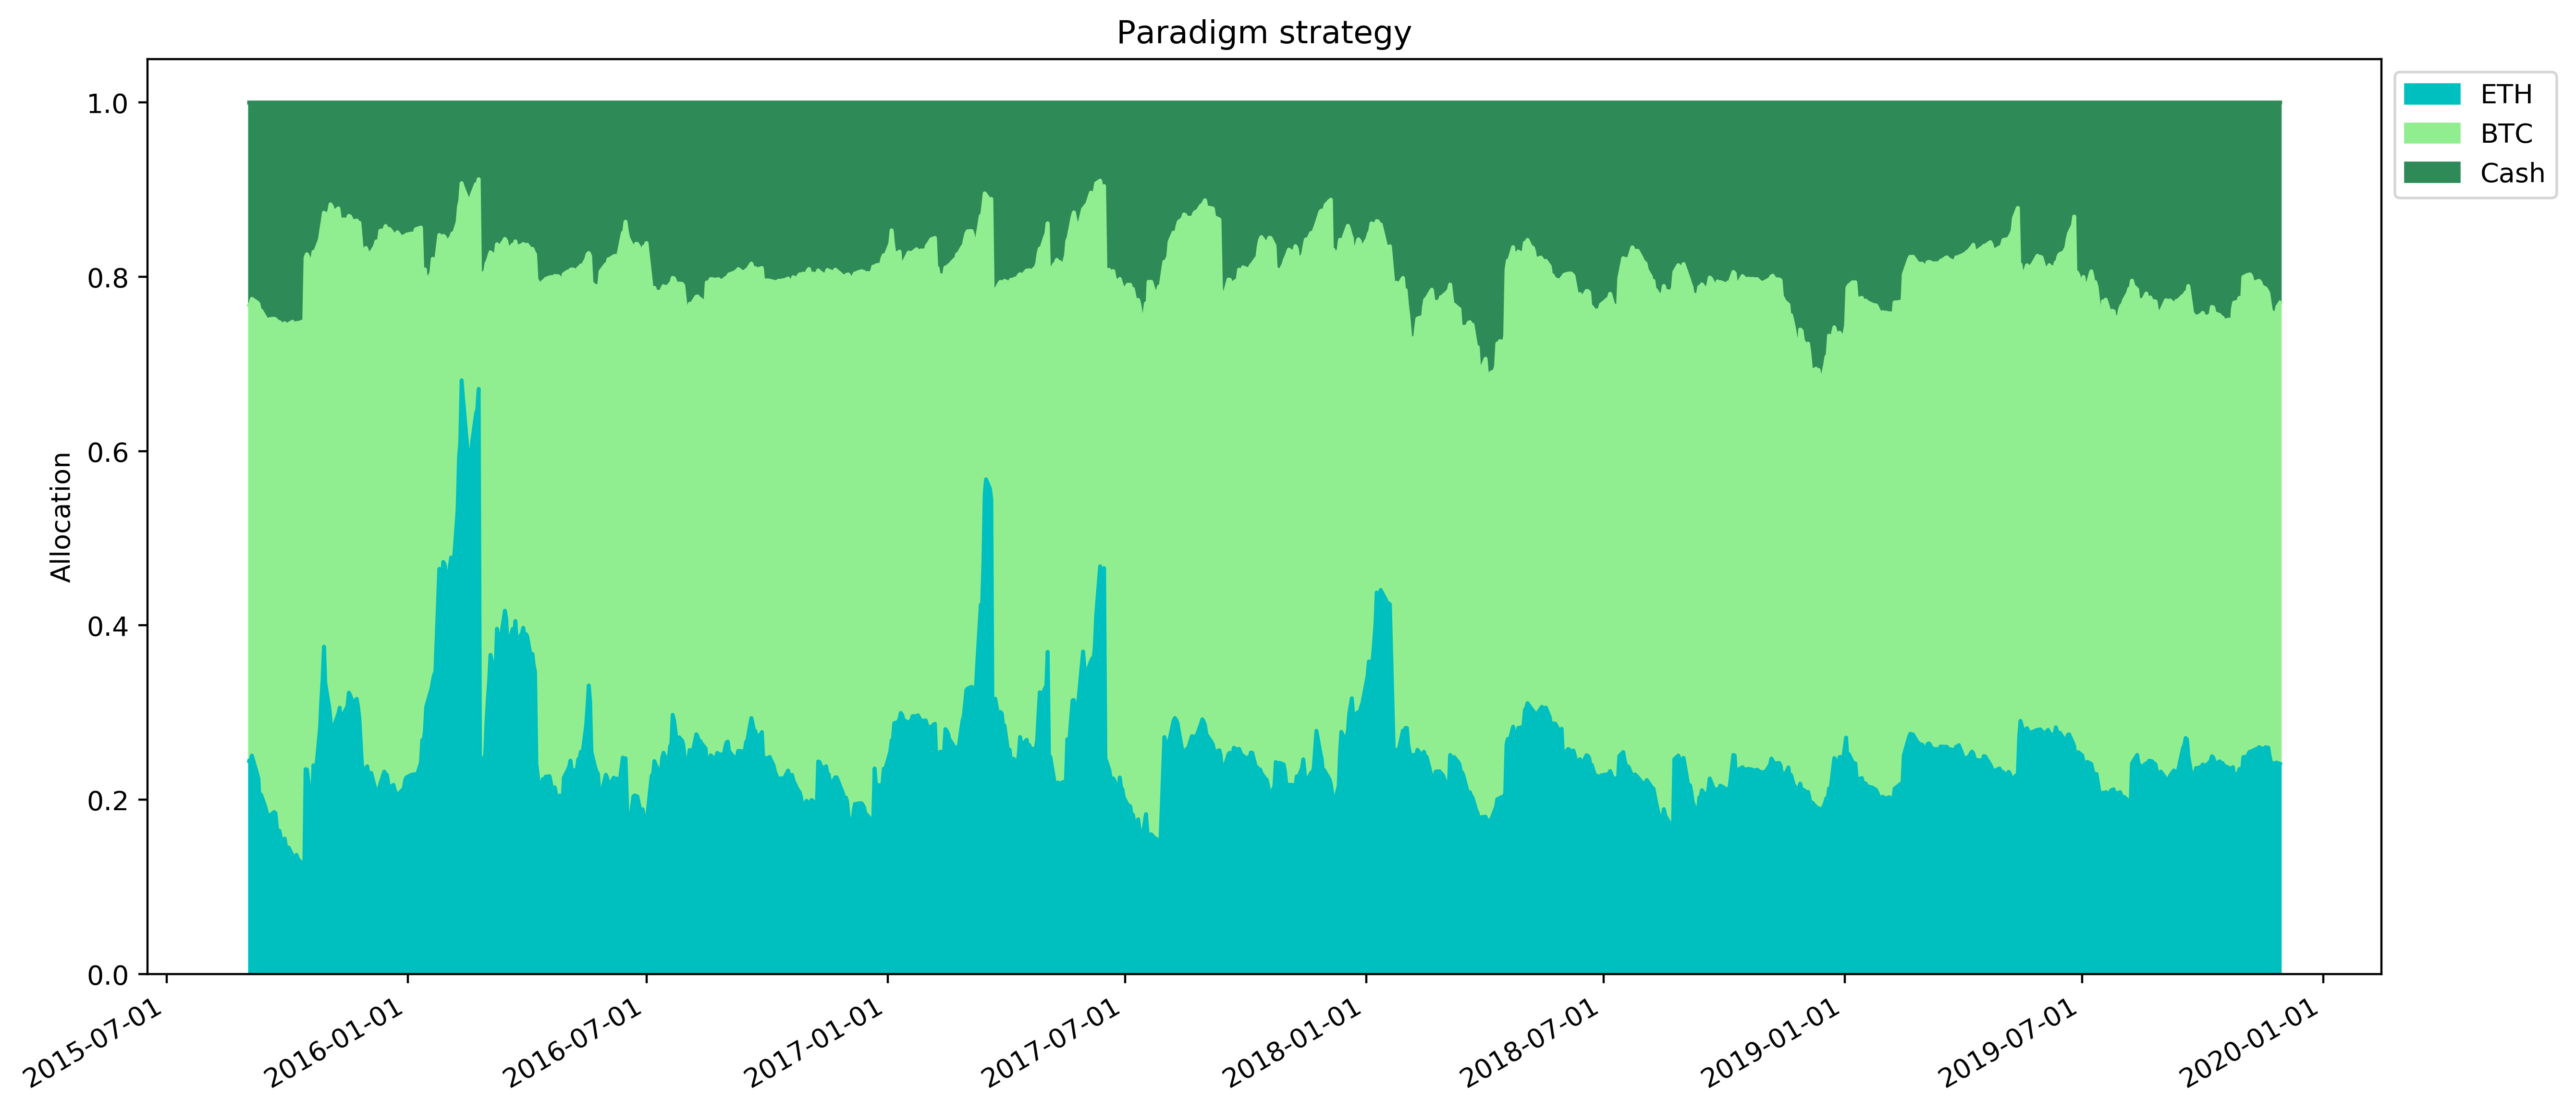

In [23]:
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# 4. Strategy without fix rebalance period

In [24]:
TIKERS = ['BTC', 'ETH']
WEIGHTS = [0.55, 0.25]
DELTA = 0.15

In [25]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=0.0007))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_count = 0

    context.time = 0

In [26]:
def handle_data(context, data):
    
    if context.time == 0:
        
        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
        context.time += 1
    
    else:
        for i, asset in enumerate(context.assets):
            #if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i])/context.weights[i] > DELTA:
            if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i]) > DELTA:
                order_target_percent(asset, context.weights[i])
                
                context.rebalance_count += 1
                
        context.time += 1
        

In [27]:
perf = zipline.run_algorithm(start=datetime(2015, 9, 1, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 1, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000,
                              handle_data=handle_data,
                              data=panel)

In [28]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

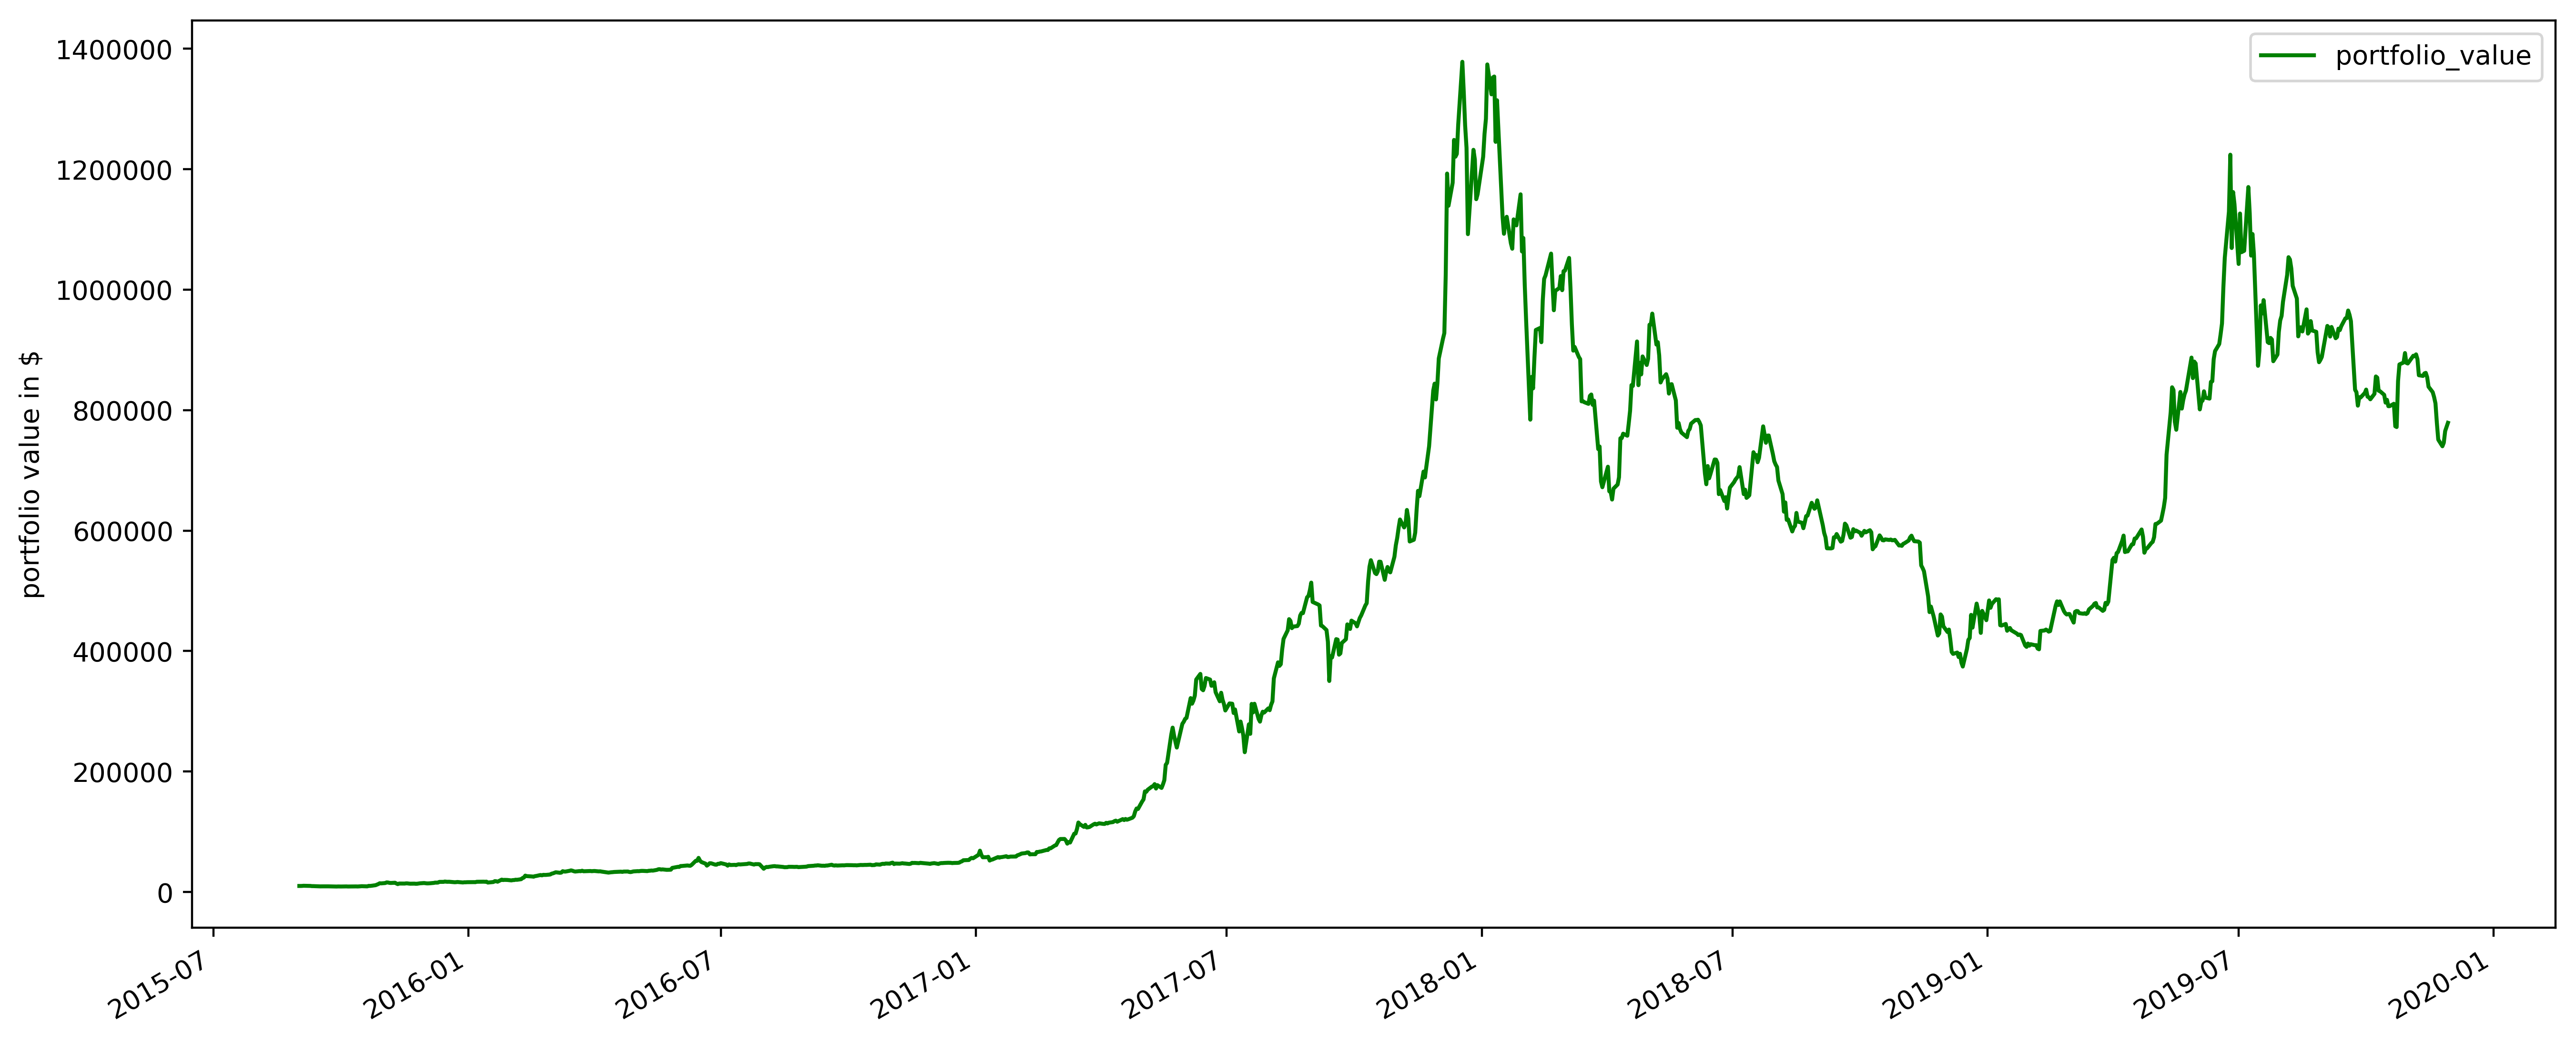

Final portfolio value (including cash): 778939.1$


In [29]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
perf.portfolio_value.plot(color='g')
ax.set_ylabel('portfolio value in $')
ax.tick_params(axis = 'x', direction = 'out')

plt.legend()
plt.show()

print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))

In [30]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)

In [31]:
# Поправляем названия столбцов

weights_df.columns = ['ETH', 'BTC', 'Cash']

In [32]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])    
norm_weights_df['ETH'] = weights_df['ETH']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])

In [33]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

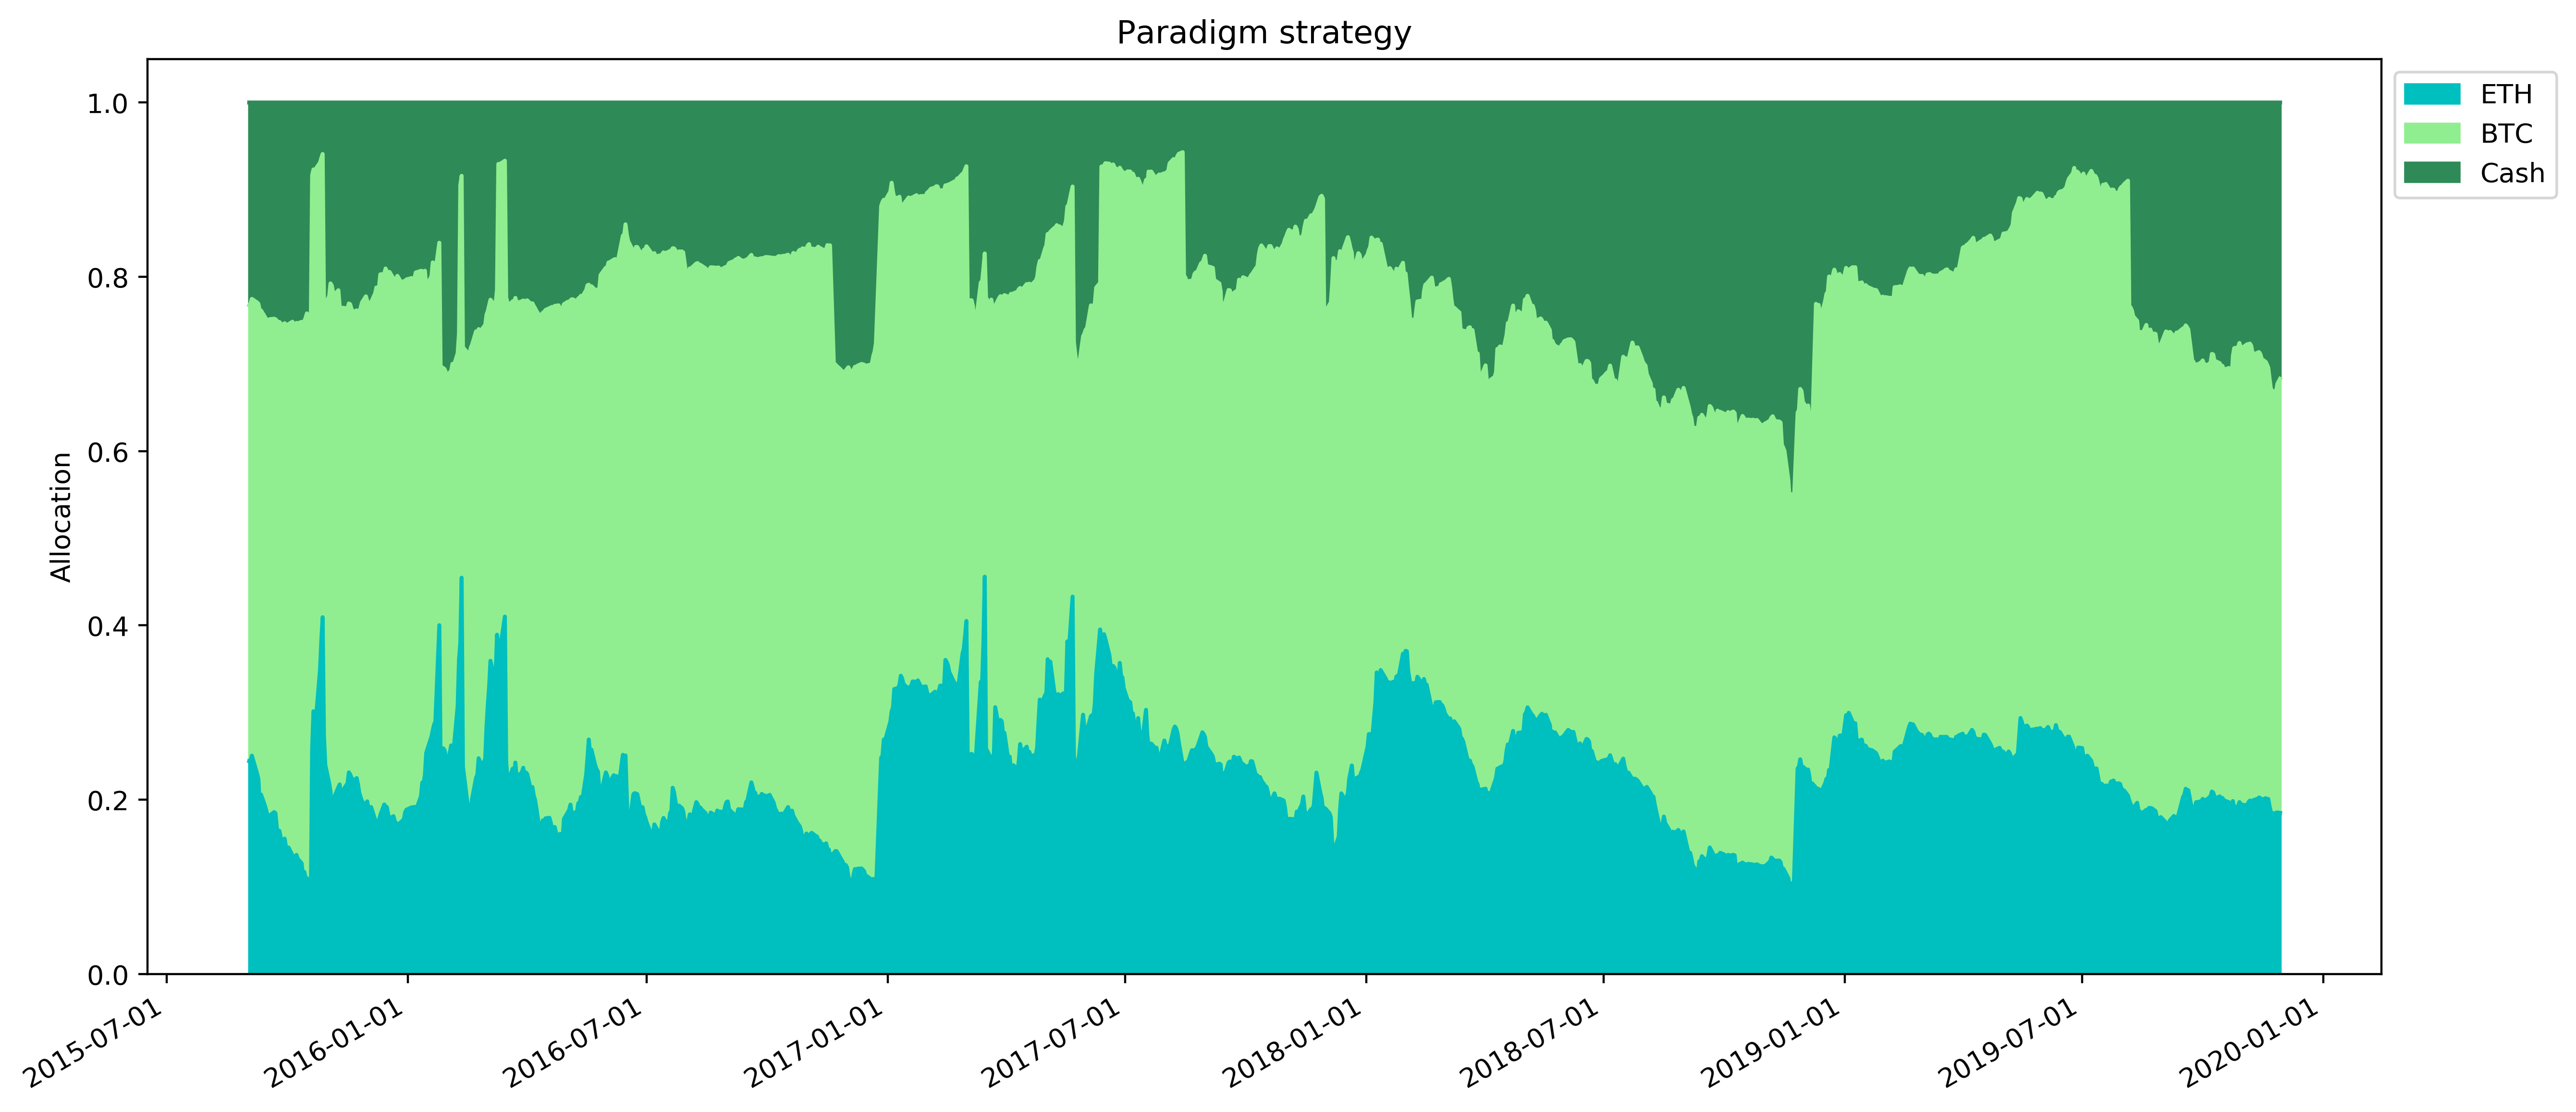

In [34]:
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# 5. Rebalance

In [35]:
TIKERS = ['BTC', 'ETH']
WEIGHTS = [0.55, 0.25]

In [36]:
profit = []

for DELTA in tqdm(range(1, 75)):
    
    def initialize(context):

        context.set_commission(commission.PerDollar(cost=0.0007))

        context.tikers = TIKERS
        context.assets = [context.symbol(symbol) for symbol in context.tikers]

        context.weights = WEIGHTS
        context.n_assets = len(context.assets)

        context.window = 1

        context.rebalance_count = 0

        context.time = 0
        
    def handle_data(context, data):

        if context.time == 0:

            # extract prices
            prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

            # submit orders
            for i, asset in enumerate(context.assets):
                order_target_percent(asset, context.weights[i])

            context.time += 1

        else:
            for i, asset in enumerate(context.assets):
                #if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i])/context.weights[i] > DELTA:
                if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i]) > DELTA/100:
                    order_target_percent(asset, context.weights[i])

                    context.rebalance_count += 1

            context.time += 1
        
        
    perf = zipline.run_algorithm(start=datetime(2015, 9, 1, 0, 0, 0, 0, pytz.utc),
                                  end=datetime(2019, 12, 1, 0, 0, 0, 0, pytz.utc),
                                  initialize=initialize,
                                  capital_base=10000,
                                  handle_data=handle_data,
                                  data=panel)
    
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
    profit.append(np.round(perf.portfolio_value[-1], 2))

100%|██████████| 74/74 [07:05<00:00,  5.75s/it]


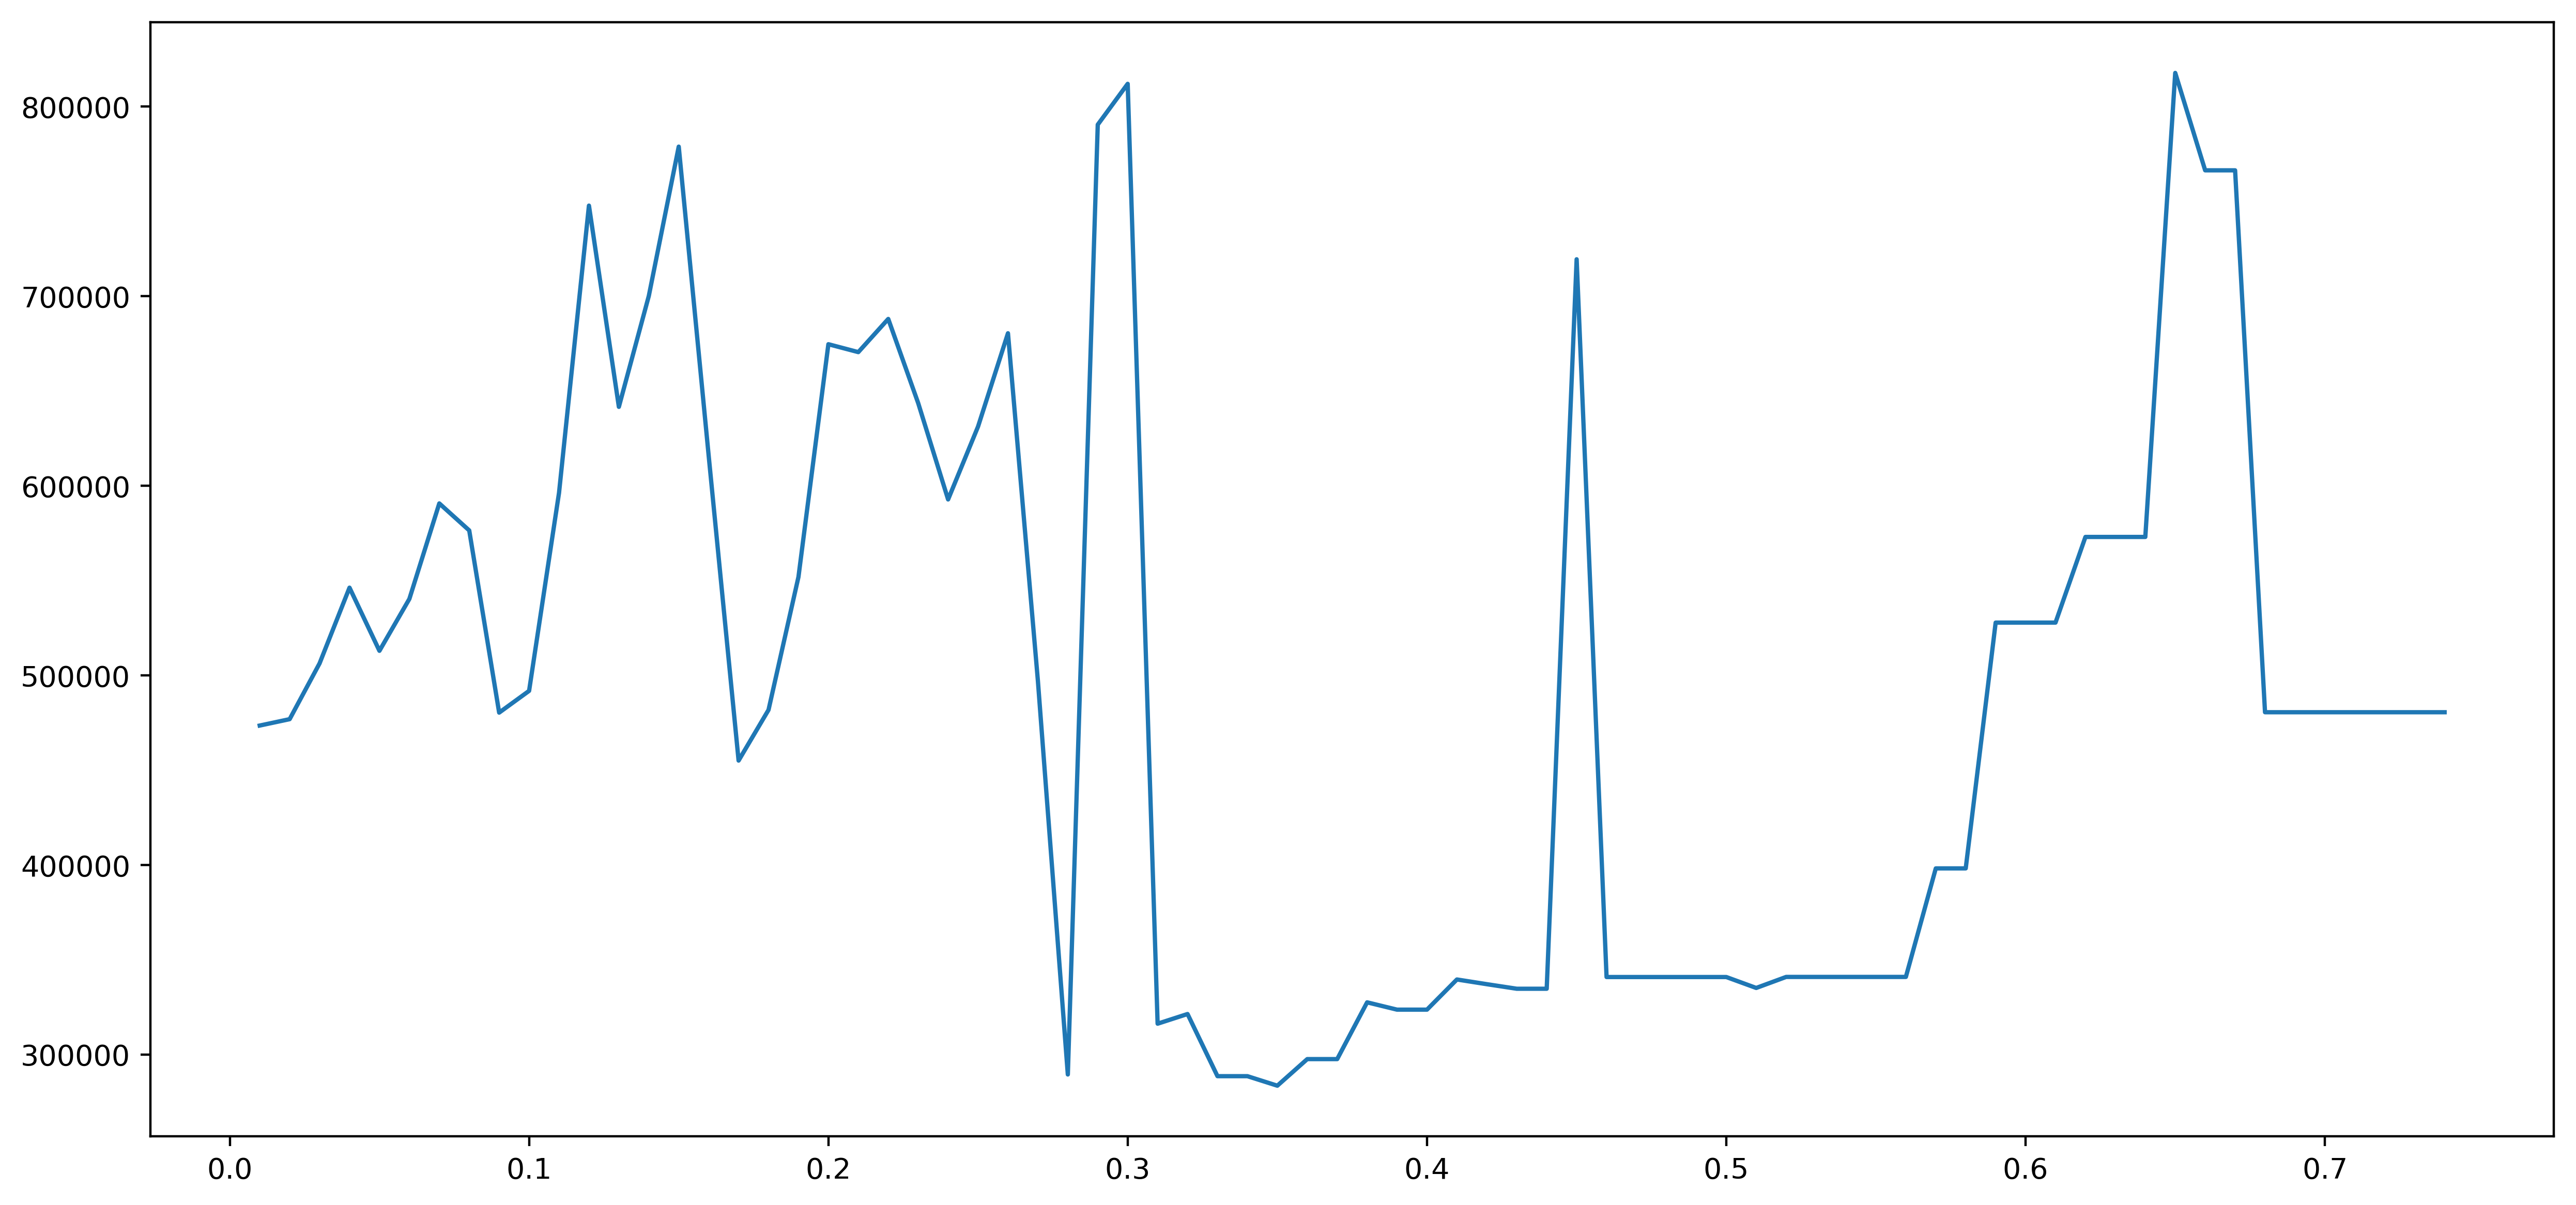

In [37]:
x = range(1, 75)
xlist = [i / 100 for i in x]
ylist = profit
plt.plot(xlist, ylist)
plt.show()